# Predicting Composer of a Musical Piece
## AAI-511 Team 7 Final Project

Team 7:  Tyler Foreman

University of San Diego, Applied Artificial Intelligence

Date:  August 12, 2024

GitHub Repository: https://github.com/t4ai/aai-511-final-project

In [2]:
!pip install pretty_midi

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, make_scorer

from random import sample
import os
import shutil
import pretty_midi

## Data Organization and Exploratory Analysis

1.  Extract music files for only the composers of interest - remove all others
2.  Conduct EDA on the target data:
  - Undersand the nature of the files and formats
  - Evaluate the distribution of samples by composer/class
  - Evaluate the length of the music tracks (in time)
  - Identify any preparation or augmentation tasks that may be necessary

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# setup target data locations
root_data_path = '/content/drive/MyDrive/USD/datasets/composers_music'
target_data_path = '/content/drive/MyDrive/USD/datasets/composers_music/target'

In [5]:
# setup data prep parameters
SETUP_MODE = False
SAMPLE_FREQUENCY = 20
NUM_PIANO_KEYS = 128

# helper function for moving and flattening directories by composer
def move_and_flatten(composer_name):
  # setup destination
  target_path = target_data_path + '/' + composer_name
  os.makedirs(target_path, exist_ok=True)

  # get source dir and subdirs
  composer_path = root_data_path + '/midiclassics/' + composer_name
  composer_dirs = [x[0] for x in os.walk(composer_path)]

  # traverse directories
  num_files = 0
  for dir in composer_dirs:
    for filename in os.listdir(dir):
      if os.path.isfile(os.path.join(dir, filename)):
        shutil.copyfile(dir + '/' + filename, target_path + '/' + filename)
        num_files += 1
  print(f'Moved {num_files} files for {composer_name}')

# helper function for loading piano rolls for a composer
def load_piano_rolls(composer_name, frequency):
  piano_rolls = []
  target_path = target_data_path + '/' + composer_name
  for filename in os.listdir(target_path):
    if filename.lower().endswith('.mid'):
      try:
        midi = pretty_midi.PrettyMIDI(target_path + '/' + filename)
        midi.remove_invalid_notes()
        piano_rolls.append(midi.get_piano_roll(fs=frequency))
      except Exception as e:
        print(f'Error reading {filename}: {e}')
  return piano_rolls

In [6]:
if SETUP_MODE==True:
  # extract only the files from our taget 4 composers: Bach, Beethoven, Mozart, Chopin
  os.makedirs(target_data_path, exist_ok=True)

  move_and_flatten('Bach')
  move_and_flatten('Beethoven')
  move_and_flatten('Mozart')
  move_and_flatten('Chopin')

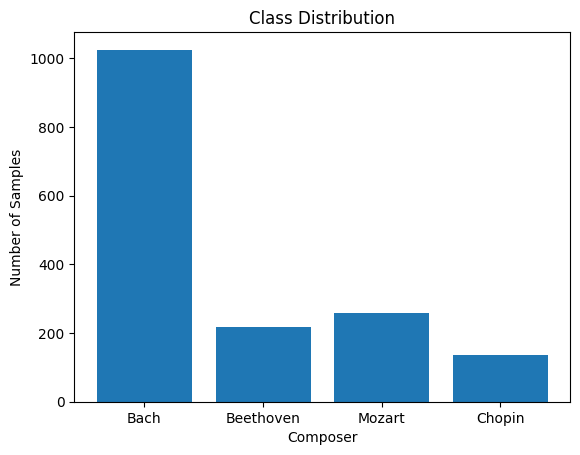

In [7]:
# visualize class balances
class_samples = {"Bach": 1025, "Beethoven": 219, "Mozart": 257, "Chopin": 136}
plt.bar(class_samples.keys(), class_samples.values())
plt.xlabel('Composer')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

In [8]:
# get the distribution of sequence lengths of the pieces (in time)
bach_data = load_piano_rolls('Bach', SAMPLE_FREQUENCY)
beethoven_data = load_piano_rolls('Beethoven', SAMPLE_FREQUENCY)
mozart_data = load_piano_rolls('Mozart', SAMPLE_FREQUENCY)
chopin_data = load_piano_rolls('Chopin', SAMPLE_FREQUENCY)

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error reading Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error reading K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


In [10]:
# build length distribution
length_distributions = []
def append_lengths(data):
  for i in range(len(data)):
    length_distributions.append(data[i].shape[1])

In [11]:
# concatenate all classes
append_lengths(bach_data)
append_lengths(beethoven_data)
append_lengths(mozart_data)
append_lengths(chopin_data)

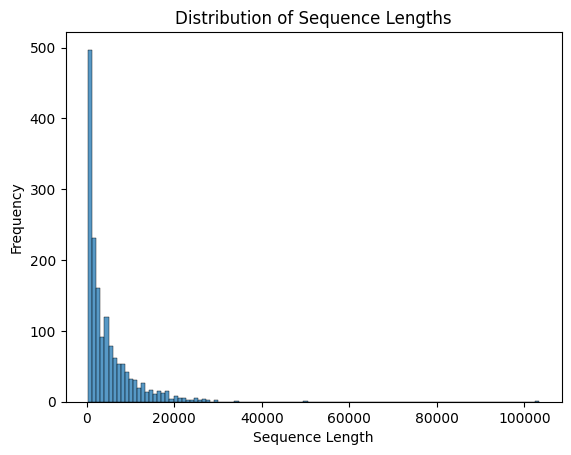

In [12]:
# plot the distribution
sns.histplot(length_distributions)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

In [13]:
# get descriptive statistics for sequence lengths
stats_df = pd.DataFrame(length_distributions)
stats_df.describe()

,0
count,1628.000000
mean,4838.340909
std,5900.262705
min,350.000000
25%,1019.750000
50%,2647.000000
75%,6518.250000
max,103362.000000


#### Analysis

There is a significant class imbalance, where Bach pieces far outweigh the number of pieces by the other composers.  Some balancing will be required - likely starting with using a subset of the Bach pieces.

There is also a wide range of sequence values.  Some preparation tasks will likely be required to normalize these to a standard sequence length for the model.  We can use the descriptive statistics to determine this - possibly breaking the larger tracks into multiple samples, each with a smaller sequence length.

## Data Preparation

1.  Fix the class imbalance issue by downsampling the over-represented class (Bach)
2.  Normalize the data using scaler
3.  Process the tracks into smaller, normalized sequence lengths
4.  Format the dataset into samples and labels suitable for model input
5.  Split the result into train/test/val

In [9]:
# set a normalized sequence length to 10 s worth of samples
NORM_SEQUENCE_LENGTH = SAMPLE_FREQUENCY * 10

# helper function to pad sequences not quite long enough
def zero_pad(seq, x, missing):
	right = np.zeros((x, missing))
	return np.hstack((seq,right))

# helper function to process track into sequences of normalized length
def process_track_to_sequences(track):
  x,y = track.shape
  #print(f"track shape:", track.shape)
  sequences = []
  if(y < NORM_SEQUENCE_LENGTH):
    sequence = zero_pad(track, x, NORM_SEQUENCE_LENGTH-y)
    #print(f"short sequence len:", sequence.shape)
    sequences.append(sequence)
  else:
    num_sequences = int(np.ceil(y / NORM_SEQUENCE_LENGTH))
    for i in range(num_sequences):
      start = i * NORM_SEQUENCE_LENGTH
      if start + NORM_SEQUENCE_LENGTH > y:
        sequence = track[:,start:y]
        zp = zero_pad(sequence, x, (start + NORM_SEQUENCE_LENGTH - y))
        #print(f"zp sequence len:", zp.shape)
        sequences.append(zp)
      else:
        end = start + NORM_SEQUENCE_LENGTH
        sequence = track[:,start:end]
        #print(f"sequence len:", sequence.shape)
        sequences.append(sequence)

  return sequences

# helper function to process all tracks for a composer into sequences
def process_composer_sequences(composer_data):
  composer_sequences = []
  for i in range(len(composer_data)):
    sequences = process_track_to_sequences(composer_data[i])
    for seq in sequences:
      #print(seq.shape)
      composer_sequences.append(seq)
  return composer_sequences

In [10]:
# process data into sequences for each composer
bach_sequences = process_composer_sequences(bach_data)
beethoven_sequences = process_composer_sequences(beethoven_data)
mozart_sequences = process_composer_sequences(mozart_data)
chopin_sequences = process_composer_sequences(chopin_data)

In [11]:
# display sequence lenghths:
print(f'Bach: {len(bach_sequences)}')
print(f'Beethoven: {len(beethoven_sequences)}')
print(f'Mozart: {len(mozart_sequences)}')
print(f'Chopin: {len(chopin_sequences)}')

Bach: 16369
Beethoven: 10399
Mozart: 10353
Chopin: 3067


In [45]:
#randomly downsample Bach sequences
#bach_sequences = sample(bach_sequences, 4000)

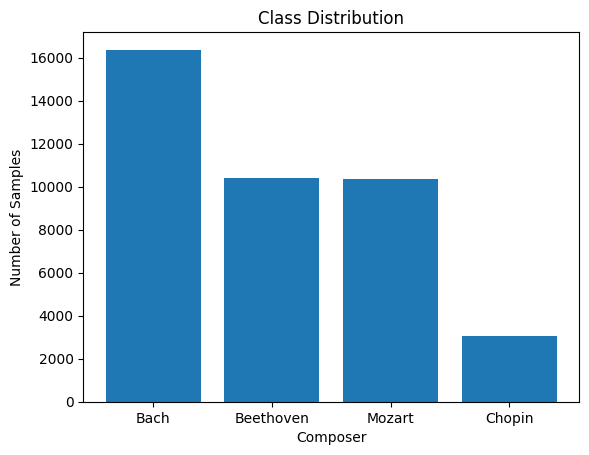

In [12]:
# visualize class balances
class_samples = {"Bach": len(bach_sequences), "Beethoven": len(beethoven_sequences), "Mozart": len(mozart_sequences), "Chopin": len(chopin_sequences)}
plt.bar(class_samples.keys(), class_samples.values())
plt.xlabel('Composer')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

In [13]:
# create labels
bach_labels = ['bach'] * len(bach_sequences)
beethoven_labels = ['beethoven'] * len(beethoven_sequences)
mozart_labels = ['mozart'] * len(mozart_sequences)
chopin_labels = ['chopin'] * len(chopin_sequences)

In [14]:
# next stack the sequences into single list
X = np.concatenate((bach_sequences, beethoven_sequences, mozart_sequences, chopin_sequences))
y_raw = np.concatenate((bach_labels, beethoven_labels, mozart_labels, chopin_labels))


In [15]:
# shuffle the dataset
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

X = X[indices]
y_raw = y_raw[indices]

In [16]:
# label encode the labels
ohe = OneHotEncoder()
y = ohe.fit_transform(y_raw.reshape(-1, 1))
y = y.toarray()
y

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [23]:
ohe.categories_

[array(['bach', 'beethoven', 'chopin', 'mozart'], dtype='<U9')]

In [17]:
# split into train/test/val
TRAIN_SPLIT = 0.8
TEST_VAL_SPLIT = 0.1
TOTAL_LEN = len(X)

# train data
X_train = X[:int(TOTAL_LEN * TRAIN_SPLIT)]
y_train = y[:int(TOTAL_LEN * TRAIN_SPLIT)]

# val data
X_val = X[int(TOTAL_LEN * TRAIN_SPLIT):int(TOTAL_LEN * (TRAIN_SPLIT + TEST_VAL_SPLIT))]
y_val = y[int(TOTAL_LEN * TRAIN_SPLIT):int(TOTAL_LEN * (TRAIN_SPLIT + TEST_VAL_SPLIT))]

# test data
X_test = X[int(TOTAL_LEN * (TRAIN_SPLIT + TEST_VAL_SPLIT)):]
y_test = y[int(TOTAL_LEN * (TRAIN_SPLIT + TEST_VAL_SPLIT)):]

In [53]:
X_train.shape

(32150, 128, 200)

In [54]:
NORM_SEQUENCE_LENGTH

200

## LSTM Model

For our first model, we will define and train and LSTM RNN model to process our sequences and perform a classification task to predict the appropriate composer.  Some experimenation and fine tuning will be conducted to find an optimal model definition.

1.  Define baseline LSTM model with classification output layer.  This will be used to validate our processed data, validate classification task and set baseline performance.
2.  Train model on our training set
3.  Evaluate performance of the model using Accuracy, Precision/Recall, F1
4.  Tune hyperparameters and model architecture



In [55]:
NUM_EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_COMPOSERS = 4

In [56]:
# define a baseline LSTM
lstm_base = tf.keras.models.Sequential([

    # input our sequence tensors
    tf.keras.layers.Input(shape=(NUM_PIANO_KEYS, NORM_SEQUENCE_LENGTH)),
    tf.keras.layers.LSTM(256, return_sequences=False, dropout=0.2),

    # classification head
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(units = NUM_COMPOSERS, activation='softmax')
])

# Compile the model
lstm_base.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()])

In [57]:
# Train the model
history_lstm = lstm_base.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/50
503/503 [==============================] - 11s 18ms/step - loss: 1.1440 - categorical_accuracy: 0.5048 - precision_4: 0.5832 - recall_4: 0.2820 - f1_score: 0.3621 - val_loss: 1.1113 - val_categorical_accuracy: 0.5307 - val_precision_4: 0.5809 - val_recall_4: 0.4198 - val_f1_score: 0.3699
Epoch 2/50
503/503 [==============================] - 8s 15ms/step - loss: 1.0749 - categorical_accuracy: 0.5558 - precision_4: 0.6081 - recall_4: 0.4101 - f1_score: 0.4319 - val_loss: 1.1213 - val_categorical_accuracy: 0.5118 - val_precision_4: 0.5851 - val_recall_4: 0.4210 - val_f1_score: 0.3467
Epoch 3/50
503/503 [==============================] - 8s 15ms/step - loss: 1.0340 - categorical_accuracy: 0.5753 - precision_4: 0.6458 - recall_4: 0.4210 - f1_score: 0.4479 - val_loss: 0.9866 - val_categorical_accuracy: 0.5770 - val_precision_4: 0.7236 - val_recall_4: 0.4058 - val_f1_score: 0.4295
Epoch 4/50
503/503 [==============================] - 8s 15ms/step - loss: 0.9599 - categorical_accura

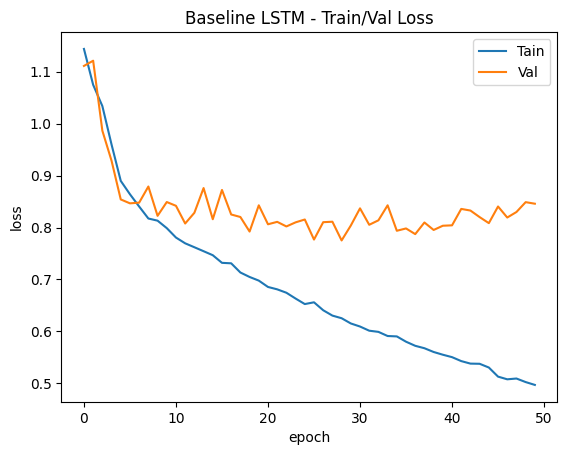

In [58]:
#plot loss
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Baseline LSTM - Train/Val Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Tain', 'Val'])
plt.show()

In [59]:
# evaluate on test data
lstm_base.evaluate(X_test, y_test)

126/126 [==============================] - 1s 7ms/step - loss: 0.8528 - categorical_accuracy: 0.6778 - precision_4: 0.7096 - recall_4: 0.6377 - f1_score: 0.6191


[0.8527677059173584,
 0.6777805685997009,
 0.7095791697502136,
 0.6377208232879639,
 array([0.836478  , 0.61980546, 0.464     , 0.556063  ], dtype=float32)]

#### Observations on Baseline LSTM

As illustrated in the loss curves above, the Baseline LSTM is overfitting on the training data.  Our next LSTM will need to incorporate techniques to mitigate this.

In [1]:
# define LSTM with mitigations for overfitting: more layers, more dropout
lstm_exp1 = tf.keras.models.Sequential([

    # input our sequence tensors
    tf.keras.layers.Input(shape=(NUM_PIANO_KEYS, NORM_SEQUENCE_LENGTH)),
    tf.keras.layers.LSTM(64, return_sequences=True, recurrent_regularizer=keras.regularizers.L1(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(64, return_sequences=True, recurrent_regularizer=keras.regularizers.L1(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(64, return_sequences=False, recurrent_regularizer=keras.regularizers.L1(0.01)),

    # classification head
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.L1(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.L1(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units = NUM_COMPOSERS, activation='softmax')
])

# Compile the model
lstm_exp1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipvalue=0.5),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
)

NameError: name 'tf' is not defined

In [ ]:
# Train the model
history_lstm_exp1 = lstm_exp1.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

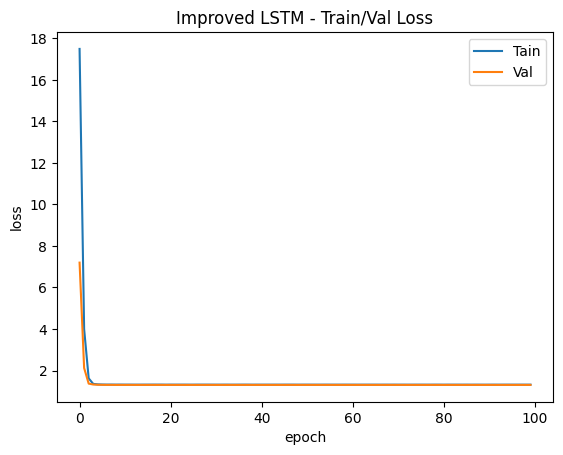

In [34]:
#plot loss
plt.plot(history_lstm_exp1.history['loss'])
plt.plot(history_lstm_exp1.history['val_loss'])
plt.title('Improved LSTM - Train/Val Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Tain', 'Val'])
plt.show()

In [35]:
# evaluate on test data
lstm_exp1.evaluate(X_test, y_test)

35/35 [==============================] - 1s 14ms/step - loss: 1.3203 - categorical_accuracy: 0.4127 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.1461


[1.320265531539917,
 0.4127272665500641,
 0.0,
 0.0,
 array([0.5842986, 0.       , 0.       , 0.       ], dtype=float32)]

In [40]:
# define LSTM with mitigations for overfitting: more layers, more dropout
lstm_exp2 = tf.keras.models.Sequential([

    # input our sequence tensors
    tf.keras.layers.Input(shape=(NUM_PIANO_KEYS, NORM_SEQUENCE_LENGTH)),
    tf.keras.layers.LSTM(512, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(512, return_sequences=False),

    # classification head
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = NUM_COMPOSERS, activation='softmax')
])

# Compile the model
lstm_exp2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipvalue=0.5),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
)

In [41]:
# Train the model
history_lstm_exp2 = lstm_exp2.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/100
161/161 [==============================] - 101s 597ms/step - loss: 1.3254 - categorical_accuracy: 0.3942 - precision_3: 0.3950 - recall_3: 0.0612 - f1_score: 0.1999 - val_loss: 1.2466 - val_categorical_accuracy: 0.4300 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.1503
Epoch 2/100
 92/161 [================>.............] - ETA: 37s - loss: 1.2536 - categorical_accuracy: 0.4236 - precision_3: 0.5250 - recall_3: 0.0785 - f1_score: 0.1687

KeyboardInterrupt: 

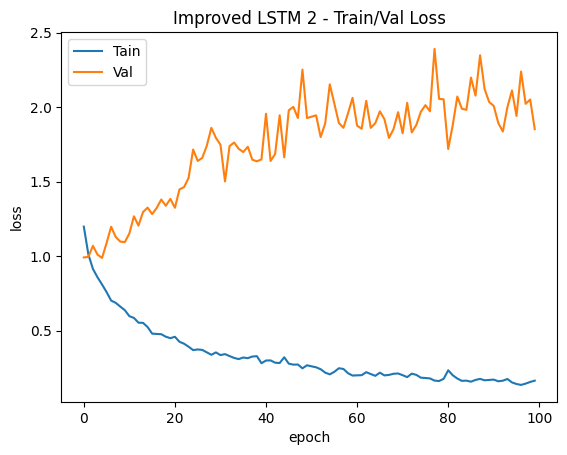

In [39]:
#plot loss
plt.plot(history_lstm_exp2.history['loss'])
plt.plot(history_lstm_exp2.history['val_loss'])
plt.title('Improved LSTM 2 - Train/Val Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Tain', 'Val'])
plt.show()